### 01. Import Dependecies

In [16]:
import os
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import (
                                    StratifiedKFold, 
                                    GridSearchCV
                                    )
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

### 02. Load the data

In [17]:
X_train = np.load('../../EDA/artifacts/logistic/X_train_cla.npz')['arr_0']
X_test = np.load('../../EDA/artifacts/logistic/X_test_cla.npz')['arr_0']
Y_train = np.load('../../EDA/artifacts/logistic/Y_train_cla.npz')['arr_0']
Y_test = np.load('../../EDA/artifacts/logistic/Y_test_cla.npz')['arr_0']

### 03. Define Paramters

In [18]:
lr_param_grid = {
    'max_iter': [1000, 5000, 10000],
    'penalty': ['l2', None],
    'C': [0.1, 1, 10]
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [6, 8, 10]
}

rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [8, 12],
    'criterion': ["gini", "entropy", "log_loss"]
}

param_grids = {
    'Logistic Regression': lr_param_grid,
    'Random Forest': rf_param_grid,
    'XGBoost': xgb_param_grid
}


### 04. Define Multi Models

In [19]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}


### 05. Configure K-Fold CV

In [20]:
cv = StratifiedKFold(
    n_splits=6,
    random_state=42,
    shuffle=True
    )

### 06. Multi Model Training

In [21]:
grid_search_results={}
model_dir = './trained_models'
for model_name, model in models.items():

    print(f"\n--- Tuning {model_name} ---")

    param_grid = param_grids[model_name]

    grid_search = GridSearchCV(
                                estimator=model,
                                param_grid=param_grid,
                                cv=cv, scoring='f1_macro',
                                verbose=1, return_train_score=False
                                )
    
    print(f"Fitting gridSearchCV for {model_name}")

    grid_search.fit(X_train, Y_train)

    grid_search_results[model_name] = grid_search
    
    print(f"{model_name} gridSearchCV completed ...")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_}")

    #Save the best trained model to joblib
    model_path = os.path.join(model_dir, f"{model_name.replace(' ', '_')}_best_model.joblib")
    joblib.dump(grid_search.best_estimator_, model_path)
    print(f"Saved best model for {model_name} at: {model_path}")


--- Tuning Logistic Regression ---
Fitting gridSearchCV for Logistic Regression
Fitting 6 folds for each of 18 candidates, totalling 108 fits
Logistic Regression gridSearchCV completed ...
Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': None}
Best CV score: 0.3303354079242628
Saved best model for Logistic Regression at: ./trained_models\Logistic_Regression_best_model.joblib

--- Tuning Random Forest ---
Fitting gridSearchCV for Random Forest
Fitting 6 folds for each of 6 candidates, totalling 36 fits
Random Forest gridSearchCV completed ...
Best parameters: {'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 100}
Best CV score: 0.3232752448623924
Saved best model for Random Forest at: ./trained_models\Random_Forest_best_model.joblib

--- Tuning XGBoost ---
Fitting gridSearchCV for XGBoost
Fitting 6 folds for each of 18 candidates, totalling 108 fits
XGBoost gridSearchCV completed ...
Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}
Best CV s

### 06. Model Evaluation

#### 6.1 Loading models

In [22]:
lr_model = joblib.load('./trained_models/Logistic_Regression_best_model.joblib')
rf_model = joblib.load('./trained_models/Random_Forest_best_model.joblib')
xgb_model = joblib.load('./trained_models/XGBoost_best_model.joblib')

# Example predictions
lr_preds = lr_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

In [27]:
class_names = ['High', 'Low', 'Medium']


def evaluate_classification_model(name, y_true, y_pred):
    print(f"\n================ {name} =================")
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

    print(f"Overall Accuracy: {accuracy:.4f}")

    for idx, cls in enumerate(class_names):
        print(f"Class '{cls}': Precision={precision[idx]:.4f} | Recall={recall[idx]:.4f} | F1-Score={f1[idx]:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title(f'{name} - Confusion Matrix')
    plt.tight_layout()
    plt.show()



================ Logistic Regression =================
Overall Accuracy: 0.3227
Class 'High': Precision=0.3375 | Recall=0.3695 | F1-Score=0.3528
Class 'Low': Precision=0.3162 | Recall=0.3688 | F1-Score=0.3405
Class 'Medium': Precision=0.3103 | Recall=0.2242 | F1-Score=0.2603

Classification Report:
              precision    recall  f1-score   support

        High       0.34      0.37      0.35       295
         Low       0.32      0.37      0.34       301
      Medium       0.31      0.22      0.26       281

    accuracy                           0.32       877
   macro avg       0.32      0.32      0.32       877
weighted avg       0.32      0.32      0.32       877



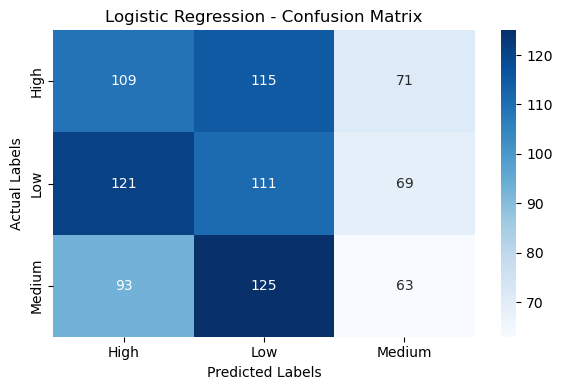


================ Random Forest =================
Overall Accuracy: 0.3387
Class 'High': Precision=0.3511 | Recall=0.3797 | F1-Score=0.3648
Class 'Low': Precision=0.3162 | Recall=0.3688 | F1-Score=0.3405
Class 'Medium': Precision=0.3575 | Recall=0.2633 | F1-Score=0.3033

Classification Report:
              precision    recall  f1-score   support

        High       0.35      0.38      0.36       295
         Low       0.32      0.37      0.34       301
      Medium       0.36      0.26      0.30       281

    accuracy                           0.34       877
   macro avg       0.34      0.34      0.34       877
weighted avg       0.34      0.34      0.34       877



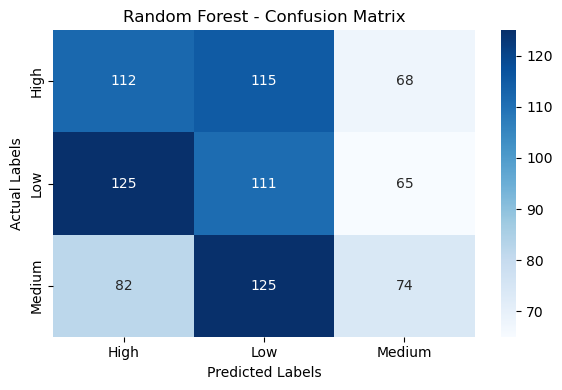


================ XGBoost =================
Overall Accuracy: 0.3375
Class 'High': Precision=0.3481 | Recall=0.3458 | F1-Score=0.3469
Class 'Low': Precision=0.3199 | Recall=0.3688 | F1-Score=0.3426
Class 'Medium': Precision=0.3502 | Recall=0.2954 | F1-Score=0.3205

Classification Report:
              precision    recall  f1-score   support

        High       0.35      0.35      0.35       295
         Low       0.32      0.37      0.34       301
      Medium       0.35      0.30      0.32       281

    accuracy                           0.34       877
   macro avg       0.34      0.34      0.34       877
weighted avg       0.34      0.34      0.34       877



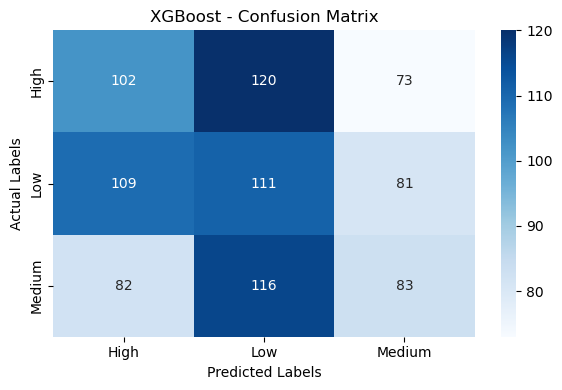

In [28]:
# Evaluate each model
for model_name, y_pred in [
    ('Logistic Regression', lr_preds),
    ('Random Forest', rf_preds),
    ('XGBoost', xgb_preds)
]:
    evaluate_classification_model(model_name, Y_test, y_pred)
